In [1]:
import gym
from gym import envs

import numpy as np
import random

from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, Reshape, Lambda, Dropout
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt

from collections import deque
import copy

Using TensorFlow backend.


Environment setting


In [0]:
# Config #
ENV="MountainCar-v0"
RANDOM_SEED=1

# random seed (reproduciblity)
np.random.seed(RANDOM_SEED)

# set the env
env=gym.make(ENV) # env to import
env.seed(RANDOM_SEED)
env.reset() # reset to env

game_steps=201 # N episodes per game
training_games=100 # N games to train


The Intrinsic Curiosity Module

In [0]:
class ICM:
    def __init__(self, env=env, training_games=training_games, 
                 game_steps=game_steps, beta=0.01, lmd=0.99):
        self.env=env #import env
        self.state_shape=env.observation_space.shape # the state space
        self.action_shape=env.action_space.n # the action space
        
        self.lmd=lmd # ratio of the external loss against the intrinsic reward
        self.beta=beta # ratio of the inverse loss against the forward reward 

        self.training_games=training_games #N training games
        self.game_steps=game_steps # N training steps
        self.batch_size=10 #training in batches
        #self.memory=deque(maxlen=2000)


        self.model=self.build_icm_model()
        self.model.compile(optimizer=Adam(), loss="mse")

        self.positions=np.zeros((self.training_games,2)) #record learning process
        self.rewards=np.zeros(self.training_games) #record learning process

    def one_hot_encode_action(self, action):
        #from int to one hot encode
        action_encoded=np.zeros(self.action_shape, np.float32)
        action_encoded[action]=1
        
        return action_encoded

    ## BUILD ICM ##
    def inverse_model(self, output_dim=3):
        """
        Predict the action (a_t)
        via the current and next states (s_t, s_t+1)
        """
        def func(f_t, f_t1): 
            #f_t, f_t1 describe the feature vector of s_t and s_t+1, respectively
            inverse_net=concatenate([f_t, f_t1])
            inverse_net=Dense(24, activation='relu')(inverse_net)
            inverse_net=Dense(output_dim, activation='sigmoid')(inverse_net)
            return inverse_net
        return func

    def forward_model(self, output_dim=2):
        """
        Predict the next state (s_t+1)
        via the current state and sction  (s_t, a_t)
        """
        def func(f_t, a_t):
            #f_t describe the feature vector of s_t
            forward_net=concatenate([f_t, a_t])
            forward_net=Dense(24, activation='relu')(forward_net)
            forward_net=Dense(output_dim, activation='linear')(forward_net)
            return forward_net
        return func

    def create_feature_vector(self, input_shape):

        model=Sequential()
        model.add(Dense(24, input_shape=input_shape, activation="relu"))
        model.add(Dense(12, activation="relu"))
        model.add(Dense(2, activation='linear', name='feature'))

        return model

    def build_icm_model(self, state_shape=(2,), action_shape=(3,)):

        s_t=Input(shape=state_shape, name="state_t") # (2,)
        s_t1=Input(shape=state_shape, name="state_t1") # (2,)
        a_t=Input(shape=action_shape, name="action") # (3,)

        reshape=Reshape(target_shape= (2,))

        feature_vector_map=self.create_feature_vector((2,))
        fv_t=feature_vector_map(reshape(s_t))
        fv_t1=feature_vector_map(reshape(s_t1))

        a_t_hat=self.inverse_model()(fv_t, fv_t1)
        s_t1_hat=self.forward_model()(fv_t, a_t)

        # the intrinsic reward refelcts the diffrence between
        # the next state versus the predicted next state
        # $r^i_t = \frac{\nu}{2}\abs{\hat{s}_{t+1}-s_{t+1})}^2$
        int_reward=Lambda(lambda x: 0.5 * K.sum(K.square(x[0] - x[1]), axis=-1),
                     output_shape=(1,),
                     name="reward_intrinsic")([fv_t1, s_t1_hat])

        #inverse model loss
        inv_loss=Lambda(lambda x: -K.sum(x[0] * K.log(x[1] + K.epsilon()), 
                                         axis=-1),
                    output_shape=(1,))([a_t, a_t_hat])

        # combined model loss - beta weighs the inverse loss against the
        # rwd (generate from the forward model)
        loss=Lambda(lambda x: self.beta * x[0] + (1.0 - self.beta) * x[1],
                    output_shape=(1,))([int_reward, inv_loss])
        #
        # lmd is lambda, the param the weights the importance of the policy
        # gradient loss against the intrinsic reward
        rwd=Input(shape=(1,))
        loss=Lambda(lambda x: (-self.lmd * x[0] + x[1]), 
                    output_shape=(1,))([rwd, loss])

        return Model([s_t, s_t1, a_t, rwd], loss)


    def learn(self, prev_states, states, actions, rewards):
        #batch train the network
        s_t=prev_states
        s_t1=states

        actions=np.array(actions)

        icm_loss=self.model.train_on_batch([s_t, s_t1,
                                        np.array(actions),
                                        np.array(rewards).reshape((-1, 1))],
                                        np.zeros((self.batch_size,)))

    def get_intrinsic_reward(self, x):
        ## x -> [prev_state, state, action]
        return K.function([self.model.get_layer("state_t").input,
                       self.model.get_layer("state_t1").input,
                       self.model.get_layer("action").input],
                      [self.model.get_layer("reward_intrinsic").output])(x)[0]
    
    def batch_train(self):
 
        # track results
        states=[]
        actions=[]
        ext_rewards=[]

        game_best_position=-.4
        positions=np.ndarray([0,2])

        for game_index in range(self.training_games):
            # observation >> the current position of Car and its velocity
            state=env.reset() # each game is a new env
            game_reward=0
            running_reward=0
            print(game_index)
            for step_index in range(self.game_steps):
                ## act ##
                # choose a random action at first, otherwise given policy net
                # push left(0), no push(1) and push right(2)
                if step_index>self.batch_size:
                  action=self.act(state)
                else:
                  action=self.env.action_space.sample()
                
                next_state, ext_reward, done, info=self.env.step(action)

                ## track restults ##
                #keep track on step properties (progress)
                action=self.one_hot_encode_action(action)


                ## get reward ##
                
                # prep data to get int reward
                int_r_state=np.reshape(state, (1,2))
                int_r_next_state=np.reshape(next_state, (1,2))
                int_r_action=np.reshape(action, (1,3))
                
                #get intrinsic reward
                int_reward=self.get_intrinsic_reward(
                                        [np.array(int_r_state),
                                         np.array(int_r_next_state),
                                         np.array(int_r_action)])
                
                #calc total reward
                reward=int_reward+ext_reward
                game_reward+=reward

                if state[0]>game_best_position:
                  game_best_position=state[0]
                  positions=np.append(positions, 
                             [[game_index, game_best_position]], axis=0)
                  
                  running_reward+=10
                else:
                  running_reward+=reward

                #move state
                state=next_state
                
                ## batch train ##
                
                # prep data for batch train
                states.append(next_state)
                ext_rewards.append(ext_reward)
                actions.append(action)

                if step_index%self.batch_size==0 and \
                  step_index>=self.batch_size:
                    all_states=states[-(self.batch_size+1):]
                    

                    self.learn(prev_states=all_states[:self.batch_size],
                                states=all_states[-self.batch_size:],
                                actions=actions[-self.batch_size:],
                                rewards=ext_rewards[-self.batch_size:])

                if done:
                    # done if reached 0.5(top) position
                    break

            self.rewards[game_index]=game_reward
            positions[-1][0]=game_index
            self.positions[game_index]=positions[-1]
            print(self.positions[game_index])

        self.show_training_data()
  
  
  
    def show_training_data(self):
        ## plot the training data
        
        self.positions[0]=[0,-0.4]
        plt.figure(1, figsize=[10,5])
        plt.subplot(211)
        plt.plot(self.positions[:,0], self.positions[:,1])
        plt.xlabel('Episode')
        plt.ylabel('Furthest Position')
        plt.subplot(212)
        plt.plot(self.rewards)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.show()

    def act(self, current_state):
        '''
        this is a less scalabe solution for the implict policy train model below

        This method samples the action space, makes a move, and 
        using the ICM minimizes
        the loss of the combined ext reward and int_reward
        '''
        losses=[]
        for action_option in range(3):

            copy_env=copy.deepcopy(self.env)
            new_state, reward, _, _ = copy_env.step(action_option)
            action_option=self.one_hot_encode_action(action_option)


            loss=self.model.predict([np.array(current_state).reshape(-1,len(current_state)),
                                        np.array(new_state).reshape(-1,len(new_state)),
                                        np.array(action_option).reshape(-1,len(action_option)),
                                        np.array(reward).reshape(-1,1)])
            losses.append(loss)

        chosen_action=np.argmax(losses)

        return chosen_action

    def make_train_policy_net_model(self, state_shape=(2,), action_shape=(3,)):
        '''
        use the ICM to train the policy models
        Currently not working due to an issue with building dynamic models in Keras
        >> thus not used.
        '''
        current_state=Input(shape=state_shape, name="state_t") # (2,)

        current_action=Lambda(lambda state_t: self.policy_net.predict(state_t),
            output_shape=(3,),
            name="predict_action")(current_state)

        next_state, reward, _, _ =self.env.step(current_action)

        loss=Lambda(lambda s_t, s_t1, a_t, rwd: self.model.predict([s_t, s_t1, a_t, rwd]),
                        output_shape=(1,),trainable=False)([current_state, next_state, current_action, reward])


        return Model(current_state, loss)


  




results

0
[ 0.         -0.18522648]
1
[ 1.         -0.18522648]
2
[ 2.         -0.05523502]
3
[ 3.         -0.05523502]
4
[ 4.         -0.05523502]
5
[ 5.         -0.05523502]
6
[ 6.         -0.05523502]
7
[7.         0.24248831]
8
[8.         0.24248831]
9
[9.         0.24248831]
10
[10.          0.24248831]
11
[11.          0.24248831]
12
[12.          0.24248831]
13
[13.          0.24248831]
14
[14.          0.24248831]
15
[15.          0.24248831]
16
[16.          0.24248831]
17
[17.          0.24248831]
18
[18.          0.24248831]
19
[19.          0.24248831]
20
[20.          0.24248831]
21
[21.          0.24248831]
22
[22.          0.24248831]
23
[23.          0.24248831]
24
[24.          0.24248831]
25
[25.          0.24248831]
26
[26.          0.24248831]
27
[27.          0.24248831]
28
[28.          0.24248831]
29
[29.          0.24248831]
30
[30.          0.24248831]
31
[31.          0.24248831]
32
[32.          0.24248831]
33
[33.          0.24248831]
34
[34.          0.24248831]
3

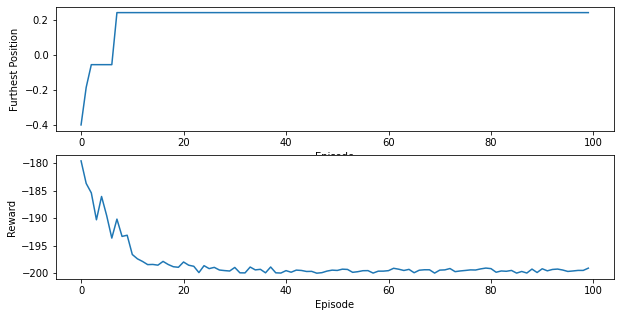

In [6]:
##lmd =0.99, beta =0.01
f=ICM(beta=0.01, lmd=0.99)
f.batch_train()


0
[ 0.         -0.23766691]
1
[ 1.         -0.00156535]
2
[ 2.00000000e+00 -1.56535465e-03]
3
[3.         0.33518511]
4
[4.         0.33518511]
5
[5.         0.33518511]
6
[6.         0.33518511]
7
[7.         0.33518511]
8
[8.         0.33518511]
9
[9.         0.33518511]
10
[10.          0.33518511]
11
[11.          0.33518511]
12
[12.          0.33518511]
13
[13.          0.33518511]
14
[14.          0.33518511]
15
[15.          0.33518511]
16
[16.          0.33518511]
17
[17.          0.33518511]
18
[18.          0.33518511]
19
[19.          0.33518511]
20
[20.          0.33518511]
21
[21.          0.33518511]
22
[22.          0.33518511]
23
[23.          0.33518511]
24
[24.          0.33518511]
25
[25.          0.33518511]
26
[26.          0.33518511]
27
[27.          0.33518511]
28
[28.          0.33518511]
29
[29.          0.33518511]
30
[30.          0.33518511]
31
[31.          0.33518511]
32
[32.          0.33518511]
33
[33.          0.33518511]
34
[34.          0.33518511]
3

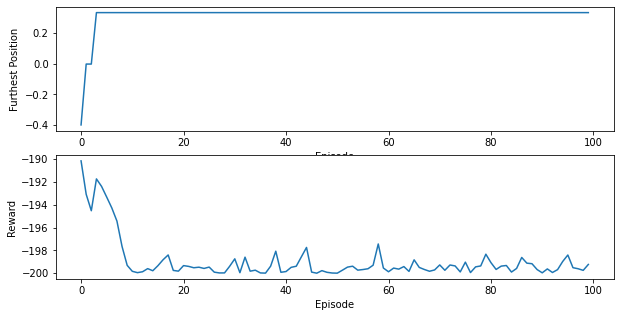

In [11]:
##lmd =0.99, b=0.1
f=ICM(beta=0.1, lmd=0.99)
f.batch_train()


0
[ 0.       -0.205488]
1
[1.         0.16831491]
2
[2.         0.16831491]
3
[3.         0.16831491]
4
[4.         0.16831491]
5
[5.         0.16831491]
6
[6.         0.16831491]
7
[7.         0.16831491]
8
[8.         0.38715295]
9
[9.         0.38715295]
10
[10.          0.38715295]
11
[11.          0.48381905]
12
[12.          0.48381905]
13
[13.          0.48381905]
14
[14.          0.48381905]
15
[15.          0.48381905]
16
[16.          0.48381905]
17
[17.          0.48381905]
18
[18.          0.48381905]
19
[19.          0.48381905]
20
[20.          0.48381905]
21
[21.          0.48381905]
22
[22.          0.48381905]
23
[23.          0.48381905]
24
[24.          0.48381905]
25
[25.          0.48381905]
26
[26.          0.48381905]
27
[27.          0.48381905]
28
[28.          0.48381905]
29
[29.          0.48381905]
30
[30.          0.48381905]
31
[31.          0.48381905]
32
[32.          0.48381905]
33
[33.          0.48381905]
34
[34.          0.48381905]
35
[35.          

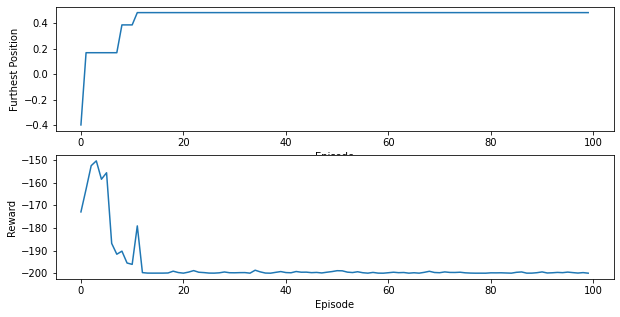

In [13]:
##lmd =0.99, b=0.2
f=ICM(beta=0.2, lmd=0.99)
f.batch_train()


0
[ 0.         -0.24600942]
1
[ 1.         -0.14557076]
2
[ 2.         -0.14557076]
3
[ 3.         -0.08573105]
4
[ 4.         -0.08573105]
5
[ 5.         -0.08573105]
6
[ 6.         -0.08573105]
7
[ 7.         -0.01462768]
8
[ 8.         -0.01462768]
9
[ 9.         -0.01462768]
10
[10.         -0.01462768]
11
[11.         -0.01462768]
12
[12.         -0.01462768]
13
[13.         -0.01462768]
14
[14.         -0.01462768]
15
[ 1.50000000e+01 -1.46276822e-02]
16
[ 1.60000000e+01 -1.46276822e-02]
17
[ 1.70000000e+01 -1.46276822e-02]
18
[ 1.80000000e+01 -1.46276822e-02]
19
[ 1.90000000e+01 -1.46276822e-02]
20
[ 2.00000000e+01 -1.46276822e-02]
21
[ 2.10000000e+01 -1.46276822e-02]
22
[ 2.20000000e+01 -1.46276822e-02]
23
[ 2.30000000e+01 -1.46276822e-02]
24
[ 2.40000000e+01 -1.46276822e-02]
25
[ 2.50000000e+01 -1.46276822e-02]
26
[ 2.60000000e+01 -1.46276822e-02]
27
[ 2.70000000e+01 -1.46276822e-02]
28
[ 2.80000000e+01 -1.46276822e-02]
29
[ 2.90000000e+01 -1.46276822e-02]
30
[ 3.00000000e+01 

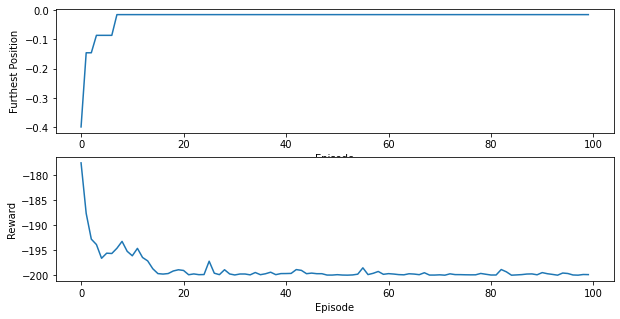

In [17]:
##lmd =0.99, b=0.5
f=ICM(beta=0.5, lmd=0.99)
f.batch_train()
